##### Copyright 2019 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples.

This notebook assumes you are familiar with Pix2Pix, which you can learn about in the [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain.

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

![Output Image 1](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_1.png?raw=1)
![Output Image 2](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_2.png?raw=1)

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/pix2pix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Blur of FMNIST Dataset of pix2pix cycleGAN.ipynb'
 cyclegan.ipynb
 FMNIST_dataset_256
'FMNIST Dataset of pix2pix cycleGAN.ipynb'
 MNIST_dataset_256
'MNIST Dataset of pix2pix cycleGAN.ipynb'


In [5]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-is7ccebe
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-is7ccebe
  Resolved https://github.com/tensorflow/examples.git to commit 6a3a323f3885f16085ad8335392f7ec836c677f4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1744662746.606450842056059708696507624557970837683594229748-py3-none-any.whl size=301631 sha256=6b0af127a7c1f37e35fcbd8ed5640df2d5218629e522c396630a7d2f5f33f80e
  Stored in directory: /tmp/pip-ephem-wheel-cache-sn8htzzv/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [6]:
import tensorflow as tf

In [7]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/catalog/cycle_gan).

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e., left to right.

In [8]:
import os
from glob import glob

trainA_path = '/content/drive/MyDrive/pix2pix/FMNIST_dataset_256/trainA'

print("Folder exists:", os.path.exists(trainA_path))
print("Files inside trainA:")
files = glob(os.path.join(trainA_path, '*'))
for f in files[:5]:  # show first 5 files
    print(" -", f)

print("Total:", len(files))

Folder exists: True
Files inside trainA:
 - /content/drive/MyDrive/pix2pix/FMNIST_dataset_256/trainA/image_20250416-141608.png
 - /content/drive/MyDrive/pix2pix/FMNIST_dataset_256/trainA/image_20250416-141640.png
 - /content/drive/MyDrive/pix2pix/FMNIST_dataset_256/trainA/image_20250416-141600.png
 - /content/drive/MyDrive/pix2pix/FMNIST_dataset_256/trainA/image_20250416-141656.png
 - /content/drive/MyDrive/pix2pix/FMNIST_dataset_256/trainA/image_20250416-141652.png
Total: 41


In [9]:
# Define paths
base_dir = '/content/drive/MyDrive/pix2pix/FMNIST_dataset_256'
trainA_path = os.path.join(base_dir, 'trainA')
trainB_path = os.path.join(base_dir, 'trainB')
testA_path = os.path.join(base_dir, 'testA')
testB_path = os.path.join(base_dir, 'testB')

# Load image file paths into datasets
def load_image_paths(directory):
    return tf.data.Dataset.list_files(directory + '/*.png', shuffle=False)

train_horses = load_image_paths(trainA_path)
train_zebras = load_image_paths(trainB_path)
test_horses = load_image_paths(testA_path)
test_zebras = load_image_paths(testB_path)

# Optional: preview one file path
for img_path in train_horses.take(1):
    print(img_path.numpy().decode())

/content/drive/MyDrive/pix2pix/FMNIST_dataset_256/trainA/image_20250416-141542.png


In [10]:
# dataset, metadata = tfds.load('cycle_gan/horse2zebra',
#                               with_info=True, as_supervised=True)

# train_horses, train_zebras = dataset['trainA'], dataset['trainB']
# test_horses, test_zebras = dataset['testA'], dataset['testB']

In [11]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
# def random_crop(image):
#   cropped_image = tf.image.random_crop(
#       image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

#   return cropped_image

In [13]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [14]:
# def random_jitter(image):
#   # resizing to 286 x 286 x 3
#   image = tf.image.resize(image, [286, 286],
#                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

#   # randomly cropping to 256 x 256 x 3
#   image = random_crop(image)

#   # random mirroring
#   image = tf.image.random_flip_left_right(image)

#   return image

In [15]:
def preprocess_image_train(image, label):
  # image = random_jitter(image)
  image = normalize(image)
  return image
# def preprocess_image_train(image):
#   # image = random_jitter(image)
#   image = normalize(image)
#   return image

In [16]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image
# def preprocess_image_test(image):
#   image = normalize(image)
#   return image

In [17]:
def decode_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])  # match your image size
    img = (img / 127.5) - 1  # normalize to [-1, 1]
    return img

In [18]:
# train_horses = train_horses.cache().map(
#     preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
#     BUFFER_SIZE).batch(BATCH_SIZE)

# train_zebras = train_zebras.cache().map(
#     preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
#     BUFFER_SIZE).batch(BATCH_SIZE)

# test_horses = test_horses.map(
#     preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
#     BUFFER_SIZE).batch(BATCH_SIZE)

# test_zebras = test_zebras.map(
#     preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
#     BUFFER_SIZE).batch(BATCH_SIZE)
train_horses = train_horses.cache().map(
    decode_img, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    decode_img, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    decode_img, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    decode_img, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

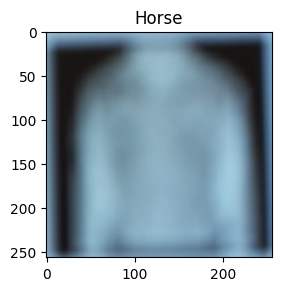

In [20]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

# plt.subplot(122)
# plt.title('Horse with random jitter')
# plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

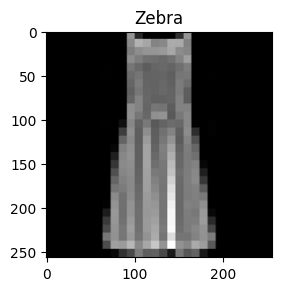

In [21]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

# plt.subplot(122)
# plt.title('Zebra with random jitter')
# plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [22]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

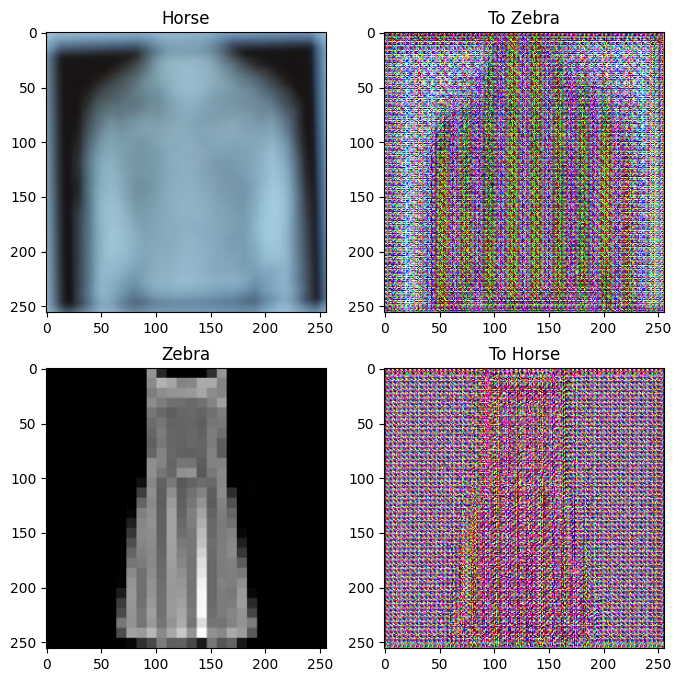

In [23]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

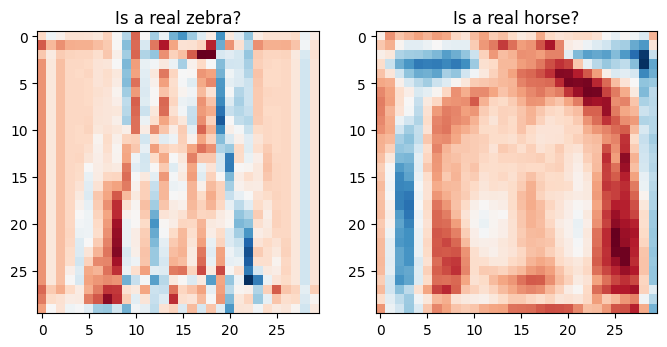

In [24]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [25]:
LAMBDA = 10

In [26]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [28]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss,

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [29]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [30]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [31]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [32]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

Note: This example model is trained for fewer epochs (10) than the paper (200) to keep training time reasonable for this tutorial. The generated images will have much lower quality.

In [33]:
EPOCHS = 10

In [34]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [35]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [36]:
def compute_prediction_loss(model, dataset, loss_type='l1'):
    total_loss = 0.0
    count = 0

    for input_img, gt_img in dataset:
        pred_img = model(input_img, training=False)

        if loss_type == 'l1':
            loss = tf.reduce_mean(tf.abs(gt_img - pred_img))
        elif loss_type == 'l2':
            loss = tf.reduce_mean(tf.square(gt_img - pred_img))
        else:
            raise ValueError("Unsupported loss type. Choose 'l1' or 'l2'.")

        total_loss += loss.numpy()
        count += 1

    avg_loss = total_loss / count
    return avg_loss

In [37]:
# === Initialize lists to store L1 and L2 test losses ===
l1_losses = []
l2_losses = []

In [38]:
import glob
import numpy as np

def load_sorted_image_paths(directory, extension='png'):
    files = sorted(glob.glob(os.path.join(directory, f'*.{extension}')))
    return tf.data.Dataset.from_tensor_slices(files)

test_horse_paths = load_sorted_image_paths(testA_path)
test_zebra_paths = load_sorted_image_paths(testB_path)

test_horses = test_horse_paths.map(decode_img, num_parallel_calls=AUTOTUNE).batch(1)
test_zebras = test_zebra_paths.map(decode_img, num_parallel_calls=AUTOTUNE).batch(1)

paired_test_dataset = tf.data.Dataset.zip((test_horses, test_zebras))

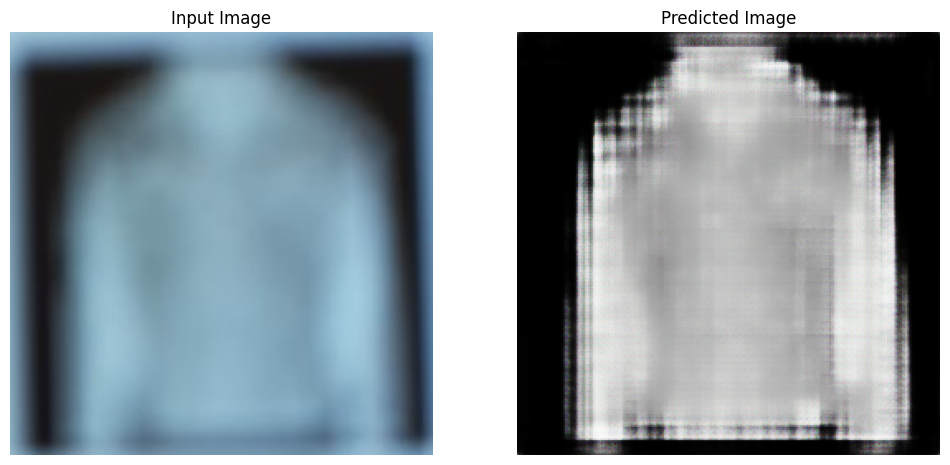

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 29.8204243183136 sec

Saved L1 and L2 losses to l1_losses.npy and l2_losses.npy.


In [39]:
# === training loop ===
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)

    # Using a consistent image to visualize progress
    generate_images(generator_g, sample_horse)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))

    # === After each epoch, compute and record L1 and L2 test loss ===
    avg_l1 = compute_prediction_loss(generator_g, paired_test_dataset, loss_type='l1')
    avg_l2 = compute_prediction_loss(generator_g, paired_test_dataset, loss_type='l2')

    l1_losses.append(avg_l1)
    l2_losses.append(avg_l2)

# === After training, save the losses to .npy files ===
np.save('FMNIST_l1_losses.npy', np.array(l1_losses))
np.save('FMNIST_l2_losses.npy', np.array(l2_losses))

print("Saved L1 and L2 losses to l1_losses.npy and l2_losses.npy.")

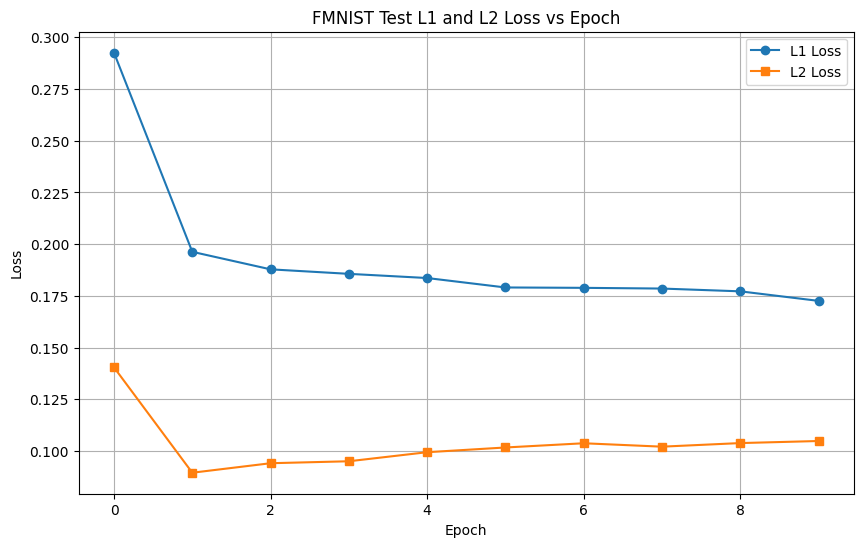

In [40]:
# === Plot L1 and L2 losses ===
epochs = range(len(l1_losses))

plt.figure(figsize=(10, 6))
plt.plot(epochs, l1_losses, label="L1 Loss", marker='o')
plt.plot(epochs, l2_losses, label="L2 Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FMNIST Test L1 and L2 Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

Saved loss plot to test_loss_plot.png.


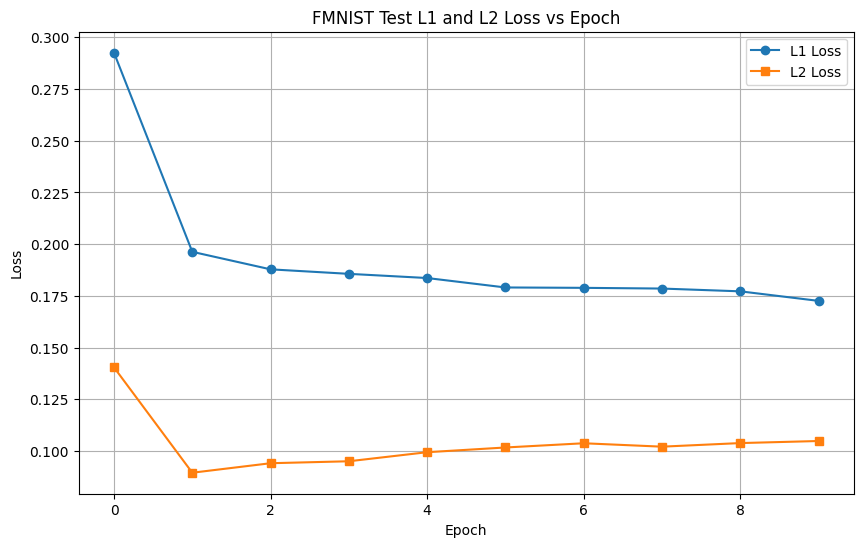

In [41]:
# === Save the plot as PNG ===
plt.figure(figsize=(10, 6))
plt.plot(epochs, l1_losses, label="L1 Loss", marker='o')
plt.plot(epochs, l2_losses, label="L2 Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FMNIST Test L1 and L2 Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.savefig('FMNIST_test_loss_plot.png')
print("Saved loss plot to test_loss_plot.png.")

In [42]:
# for epoch in range(EPOCHS):
#   start = time.time()

#   n = 0
#   for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
#     train_step(image_x, image_y)
#     if n % 10 == 0:
#       print ('.', end='')
#     n += 1

#   clear_output(wait=True)
#   # Using a consistent image (sample_horse) so that the progress of the model
#   # is clearly visible.
#   generate_images(generator_g, sample_horse)

#   if (epoch + 1) % 5 == 0:
#     ckpt_save_path = ckpt_manager.save()
#     print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
#                                                          ckpt_save_path))

#   print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
#                                                       time.time()-start))

## Generate using test dataset

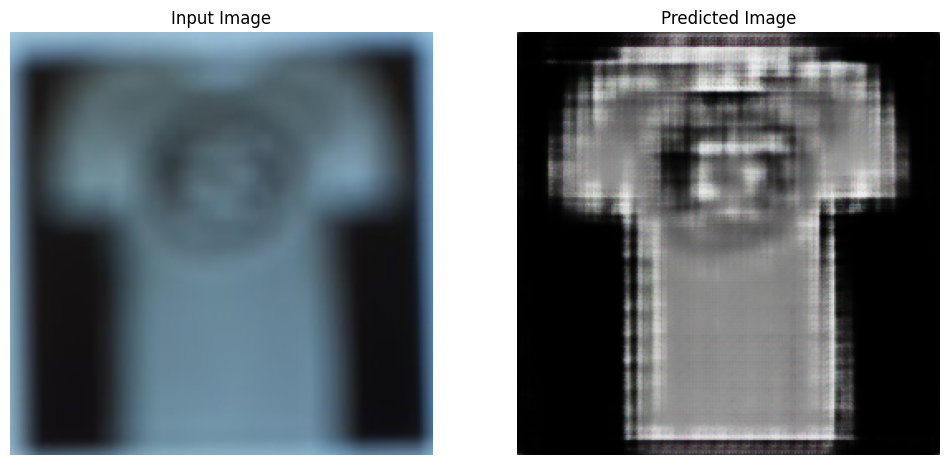

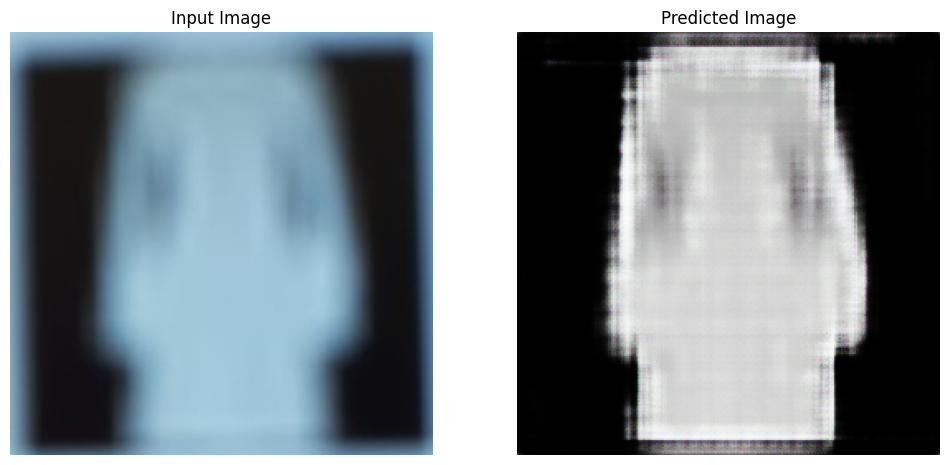

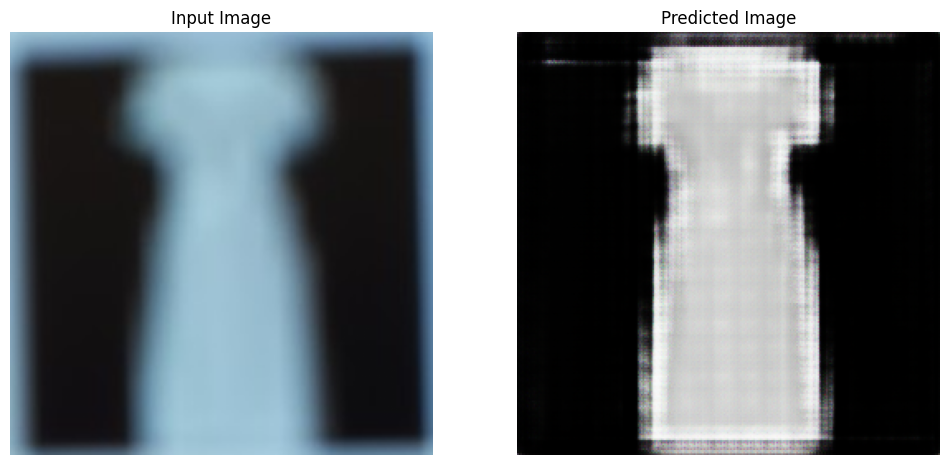

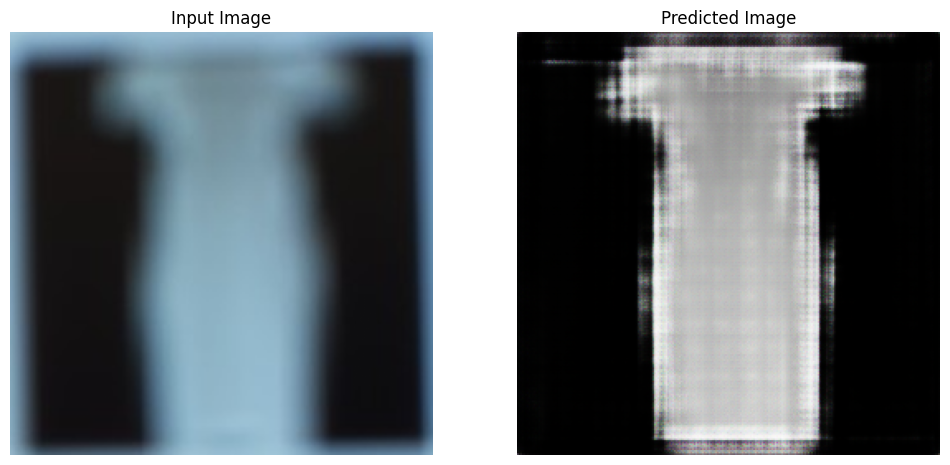

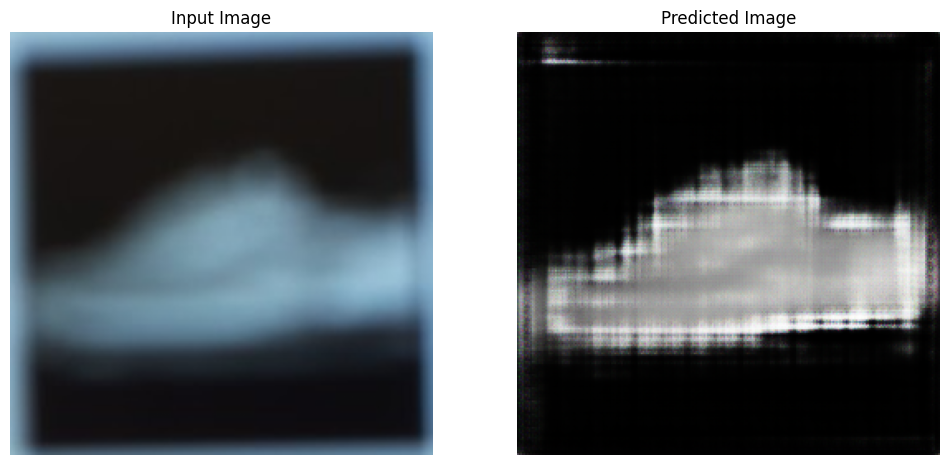

In [43]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

In [44]:
import glob

def load_sorted_image_paths(directory, extension='png'):
    files = sorted(glob.glob(os.path.join(directory, f'*.{extension}')))
    return tf.data.Dataset.from_tensor_slices(files)

In [45]:
test_horse_paths = load_sorted_image_paths(testA_path)
test_zebra_paths = load_sorted_image_paths(testB_path)

In [46]:
test_horses = test_horse_paths.map(decode_img, num_parallel_calls=AUTOTUNE).batch(1)
test_zebras = test_zebra_paths.map(decode_img, num_parallel_calls=AUTOTUNE).batch(1)

In [47]:
paired_test_dataset = tf.data.Dataset.zip((test_horses, test_zebras))

In [48]:
for a, b in zip(sorted(glob.glob(testA_path + '/*.png')),
                sorted(glob.glob(testB_path + '/*.png'))):
    print(os.path.basename(a), " ↔ ", os.path.basename(b))

image_20250416-141708.png  ↔  image_49_label_0.png
image_20250416-141710.png  ↔  image_50_label_3.png
image_20250416-141712.png  ↔  image_51_label_3.png
image_20250416-141714.png  ↔  image_52_label_3.png
image_20250416-141716.png  ↔  image_53_label_7.png
image_20250416-141718.png  ↔  image_54_label_2.png
image_20250416-141720.png  ↔  image_55_label_2.png
image_20250416-141724.png  ↔  image_56_label_6.png
image_20250416-141726.png  ↔  image_57_label_6.png
image_20250416-141728.png  ↔  image_58_label_5.png


In [49]:
def compute_metrics(gt, pred):
    gt = (gt + 1.0) / 2.0
    pred = (pred + 1.0) / 2.0
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0)
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0)
    return tf.reduce_mean(ssim_val), tf.reduce_mean(psnr_val)

def evaluate_pix2pix_model(model, dataset):
    total_ssim, total_psnr, count = 0.0, 0.0, 0
    for input_img, gt_img in dataset:
        pred_img = model(input_img, training=False)
        ssim_val, psnr_val = compute_metrics(gt_img, pred_img)
        total_ssim += ssim_val
        total_psnr += psnr_val
        count += 1
    print(f"Avg SSIM: {total_ssim/count:.4f} | Avg PSNR: {total_psnr/count:.2f} dB")

In [50]:
evaluate_pix2pix_model(generator_g, paired_test_dataset)

Avg SSIM: 0.5649 | Avg PSNR: 15.91 dB


In [51]:
def visualize_prediction(model, input_img, ground_truth_img):
    prediction = model(input_img, training=False)

    # Compute SSIM & PSNR (Prediction vs Ground Truth)
    ssim_val, psnr_val = compute_metrics(ground_truth_img, prediction)

    # Compute L1 and L2 losses
    l1_loss = tf.reduce_mean(tf.abs(ground_truth_img - prediction)).numpy()
    l2_loss = tf.reduce_mean(tf.square(ground_truth_img - prediction)).numpy()

    # Convert to [0, 1] for display
    display_input = input_img[0] * 0.5 + 0.5
    display_pred = prediction[0] * 0.5 + 0.5
    display_gt = ground_truth_img[0] * 0.5 + 0.5

    titles = ["Input", "Prediction", "Ground Truth"]
    images = [display_input, display_pred, display_gt]

    plt.figure(figsize=(18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i])
        plt.axis("off")

    # Add global caption with all metrics
    plt.figtext(
        0.5, -0.03,
        f"SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB | L1 Loss: {l1_loss:.4f} | L2 Loss: {l2_loss:.4f}",
        ha="center", fontsize=14
    )
    plt.tight_layout()
    plt.show()

In [52]:
for input_img, gt_img in paired_test_dataset.take(10):
    visualize_prediction(generator_g, input_img, gt_img)

Output hidden; open in https://colab.research.google.com to view.

In [53]:
def compute_test_loss(test_dataset_x, test_dataset_y):
    total_gen_g_loss, total_gen_f_loss = 0.0, 0.0
    total_disc_x_loss, total_disc_y_loss = 0.0, 0.0
    count = 0

    for real_x, real_y in tf.data.Dataset.zip((test_dataset_x, test_dataset_y)):
        # Forward pass without training
        fake_y = generator_g(real_x, training=False)
        cycled_x = generator_f(fake_y, training=False)

        fake_x = generator_f(real_y, training=False)
        cycled_y = generator_g(fake_x, training=False)

        same_x = generator_f(real_x, training=False)
        same_y = generator_g(real_y, training=False)

        disc_real_x = discriminator_x(real_x, training=False)
        disc_real_y = discriminator_y(real_y, training=False)

        disc_fake_x = discriminator_x(fake_x, training=False)
        disc_fake_y = discriminator_y(fake_y, training=False)

        # Compute all losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_gen_g = gen_g_loss + total_cycle + identity_loss(real_y, same_y)
        total_gen_f = gen_f_loss + total_cycle + identity_loss(real_x, same_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

        # Accumulate
        total_gen_g_loss += total_gen_g.numpy()
        total_gen_f_loss += total_gen_f.numpy()
        total_disc_x_loss += disc_x_loss.numpy()
        total_disc_y_loss += disc_y_loss.numpy()
        count += 1

    print(f"Avg Generator G Loss: {total_gen_g_loss / count:.4f}")
    print(f"Avg Generator F Loss: {total_gen_f_loss / count:.4f}")
    print(f"Avg Discriminator X Loss: {total_disc_x_loss / count:.4f}")
    print(f"Avg Discriminator Y Loss: {total_disc_y_loss / count:.4f}")

In [54]:
compute_test_loss(test_horses, test_zebras)

Avg Generator G Loss: 2.2129
Avg Generator F Loss: 2.1966
Avg Discriminator X Loss: 0.6672
Avg Discriminator Y Loss: 0.6889


In [55]:
def compute_prediction_loss(model, dataset, loss_type='l1'):
    total_loss = 0.0
    count = 0

    for input_img, gt_img in dataset:
        pred_img = model(input_img, training=False)

        if loss_type == 'l1':
            loss = tf.reduce_mean(tf.abs(gt_img - pred_img))
        elif loss_type == 'l2':
            loss = tf.reduce_mean(tf.square(gt_img - pred_img))
        else:
            raise ValueError("Unsupported loss type. Choose 'l1' or 'l2'.")

        total_loss += loss.numpy()
        count += 1

    print(f"Avg {loss_type.upper()} Loss: {total_loss / count:.4f}")

In [56]:
compute_prediction_loss(generator_g, paired_test_dataset, loss_type='l1')

Avg L1 Loss: 0.1726


In [57]:
compute_prediction_loss(generator_g, paired_test_dataset, loss_type='l2')

Avg L2 Loss: 0.1048


## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan).

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.

# Robustness testing

Apply Gaussian blur to images from test_horses

Gradually increase blur level (e.g., σ = 0, 1, 2, 3, 4, ...)

Feed each blurred version to generator_g (Horse → Zebra)

Record test losses (L1, L2, SSIM, PSNR) at each blur level

In [65]:
# ==== Gaussian blur ========
import cv2
import numpy as np

def apply_gaussian_blur_cv(img, sigma):
    if sigma == 0:
        return img
    # Convert to numpy and [0, 255] range
    img_np = (img.numpy() * 127.5 + 127.5).astype(np.uint8)
    blurred_np = cv2.GaussianBlur(img_np, ksize=(0, 0), sigmaX=sigma)
    # Back to float32 [−1, 1]
    blurred_tf = tf.convert_to_tensor((blurred_np.astype(np.float32) - 127.5) / 127.5)
    return blurred_tf

# def get_blurred_dataset(dataset, sigma):
#     def blur_fn(img):
#         return apply_gaussian_blur(img, sigma)
#     return dataset.map(lambda img: blur_fn(img), num_parallel_calls=tf.data.AUTOTUNE)

In [66]:
# ===== Visualization ======
def visualize_blur_level_cv(model, input_img, gt_img, sigma):
    # Apply OpenCV Gaussian blur
    blurred_input = apply_gaussian_blur_cv(input_img[0], sigma)
    blurred_input = tf.expand_dims(blurred_input, axis=0)  # shape: (1, H, W, C)

    pred = model(blurred_input, training=False)

    # Compute metrics
    l1 = tf.reduce_mean(tf.abs(gt_img - pred)).numpy()
    l2 = tf.reduce_mean(tf.square(gt_img - pred)).numpy()
    ssim_val, psnr_val = compute_metrics(gt_img, pred)
    ssim_val, psnr_val = ssim_val.numpy(), psnr_val.numpy()

    # Display images
    display_input = blurred_input[0] * 0.5 + 0.5
    display_pred = pred[0] * 0.5 + 0.5
    display_gt = gt_img[0] * 0.5 + 0.5

    plt.figure(figsize=(18, 6))
    titles = ["Blurred Input", "Prediction", "Ground Truth"]
    images = [display_input, display_pred, display_gt]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis("off")

    plt.figtext(0.5, -0.03,
                f"Blur level σ: {sigma} | L1: {l1:.4f} | L2: {l2:.4f} | SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB",
                ha="center", fontsize=14)
    plt.tight_layout()
    plt.show()

    return l1, l2, ssim_val, psnr_val

In [78]:
# Pick 1 test sample
test_sample = next(iter(tf.data.Dataset.zip((test_horses, test_zebras)).take(1)))
input_img, gt_img = test_sample

blur_sigmas = list(range(0, 51, 2))  # [0, 2, 4, ..., 30]
l1_all, l2_all, ssim_all, psnr_all = [], [], [], []

for sigma in blur_sigmas:
    print(f"Evaluating Blur level σ = {sigma}")
    l1, l2, ssim_val, psnr_val = visualize_blur_level_cv(generator_g, input_img, gt_img, sigma)
    l1_all.append(l1)
    l2_all.append(l2)
    ssim_all.append(ssim_val)
    psnr_all.append(psnr_val)


plt.figure(figsize=(10, 6))
plt.plot(blur_sigmas, l1_all, label="L1 Loss", marker='o')
plt.plot(blur_sigmas, l2_all, label="L2 Loss", marker='s')
plt.plot(blur_sigmas, ssim_all, label="SSIM", marker='^')
plt.plot(blur_sigmas, psnr_all, label="PSNR (dB)", marker='x')

plt.xlabel("Blur Sigma")
plt.ylabel("Metric Value")
plt.title("CycleGAN Performance vs Input Blur")
plt.legend()
plt.grid(True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

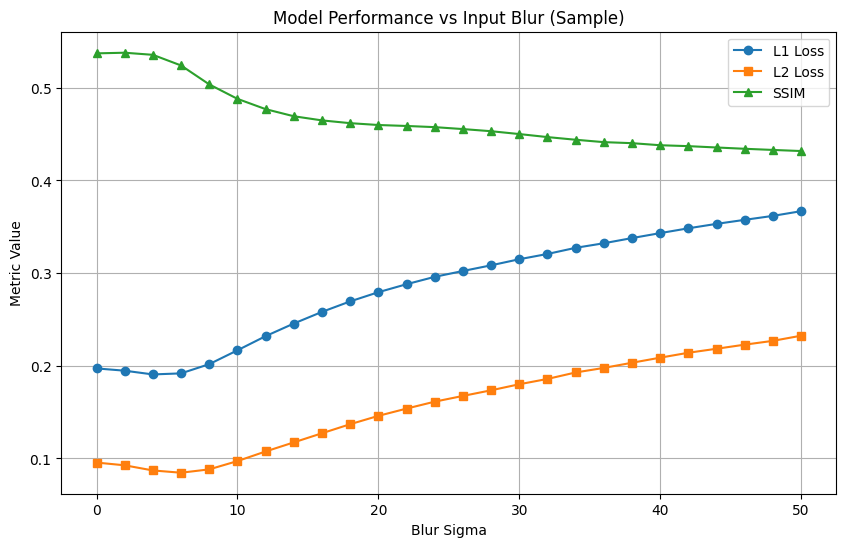

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(blur_sigmas, l1_all, label="L1 Loss", marker='o')
plt.plot(blur_sigmas, l2_all, label="L2 Loss", marker='s')
plt.plot(blur_sigmas, ssim_all, label="SSIM", marker='^')


plt.xlabel("Blur Sigma")
plt.ylabel("Metric Value")
plt.title("Model Performance vs Input Blur (Sample)")
plt.legend()
plt.grid(True)
plt.show()

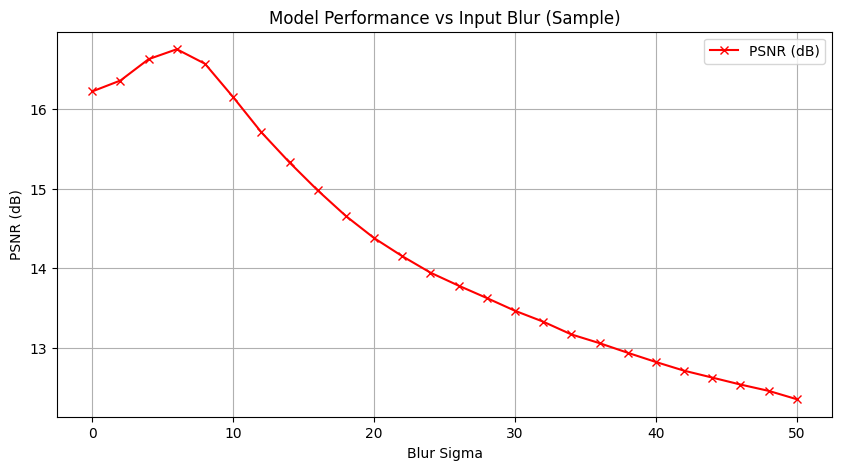

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(blur_sigmas, psnr_all, label="PSNR (dB)", color='red', marker='x')
plt.xlabel("Blur Sigma")
plt.ylabel("PSNR (dB)")
plt.title("Model Performance vs Input Blur (Sample)")
plt.grid(True)
plt.legend()
plt.show()

In [74]:
def evaluate_model_on_blurred_dataset(model, test_inputs, test_targets, sigma):
    total_l1, total_l2, total_ssim, total_psnr = 0.0, 0.0, 0.0, 0.0
    count = 0

    for input_img, gt_img in tf.data.Dataset.zip((test_inputs, test_targets)):
        # Apply OpenCV Gaussian blur
        blurred_img = apply_gaussian_blur_cv(input_img[0], sigma)
        blurred_img = tf.expand_dims(blurred_img, axis=0)

        pred = model(blurred_img, training=False)

        total_l1 += tf.reduce_mean(tf.abs(gt_img - pred)).numpy()
        total_l2 += tf.reduce_mean(tf.square(gt_img - pred)).numpy()

        ssim_val, psnr_val = compute_metrics(gt_img, pred)
        total_ssim += ssim_val.numpy()
        total_psnr += psnr_val.numpy()

        count += 1

    return (total_l1 / count, total_l2 / count,
            total_ssim / count, total_psnr / count)

In [85]:
blur_sigmas = list(range(0, 51, 2))  # e.g., sigma from 0 to 50

l1_all, l2_all, ssim_all, psnr_all = [], [], [], []

for sigma in blur_sigmas:
    print(f"Evaluating entire test set with sigma = {sigma}")
    l1, l2, ssim, psnr = evaluate_model_on_blurred_dataset(generator_g, test_horses, test_zebras, sigma)
    l1_all.append(l1)
    l2_all.append(l2)
    ssim_all.append(ssim)
    psnr_all.append(psnr)

Evaluating entire test set with sigma = 0
Evaluating entire test set with sigma = 2
Evaluating entire test set with sigma = 4
Evaluating entire test set with sigma = 6
Evaluating entire test set with sigma = 8
Evaluating entire test set with sigma = 10
Evaluating entire test set with sigma = 12
Evaluating entire test set with sigma = 14
Evaluating entire test set with sigma = 16
Evaluating entire test set with sigma = 18
Evaluating entire test set with sigma = 20
Evaluating entire test set with sigma = 22
Evaluating entire test set with sigma = 24
Evaluating entire test set with sigma = 26
Evaluating entire test set with sigma = 28
Evaluating entire test set with sigma = 30
Evaluating entire test set with sigma = 32
Evaluating entire test set with sigma = 34
Evaluating entire test set with sigma = 36
Evaluating entire test set with sigma = 38
Evaluating entire test set with sigma = 40
Evaluating entire test set with sigma = 42
Evaluating entire test set with sigma = 44
Evaluating entir

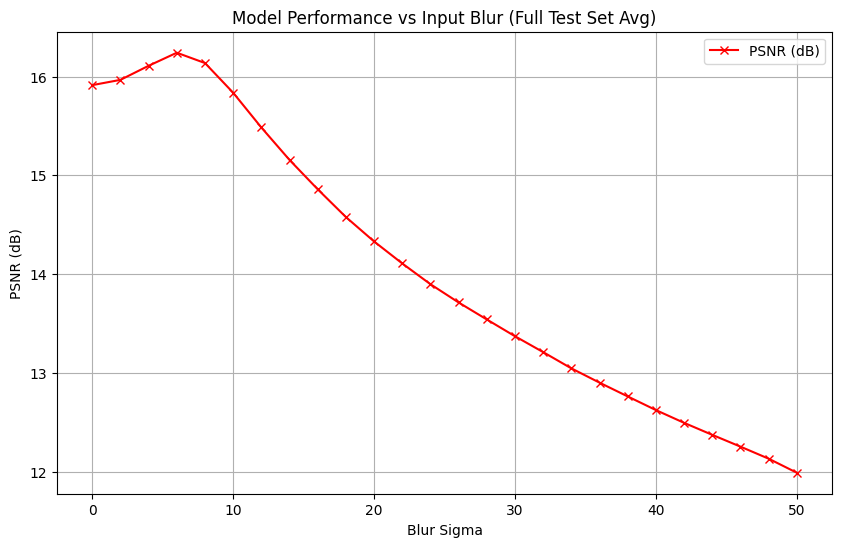

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(blur_sigmas, psnr_all, label="PSNR (dB)", color='red', marker='x')
plt.xlabel("Blur Sigma")
plt.ylabel("PSNR (dB)")
plt.title("Model Performance vs Input Blur (Full Test Set Avg)")
plt.grid(True)
plt.legend()
plt.show()

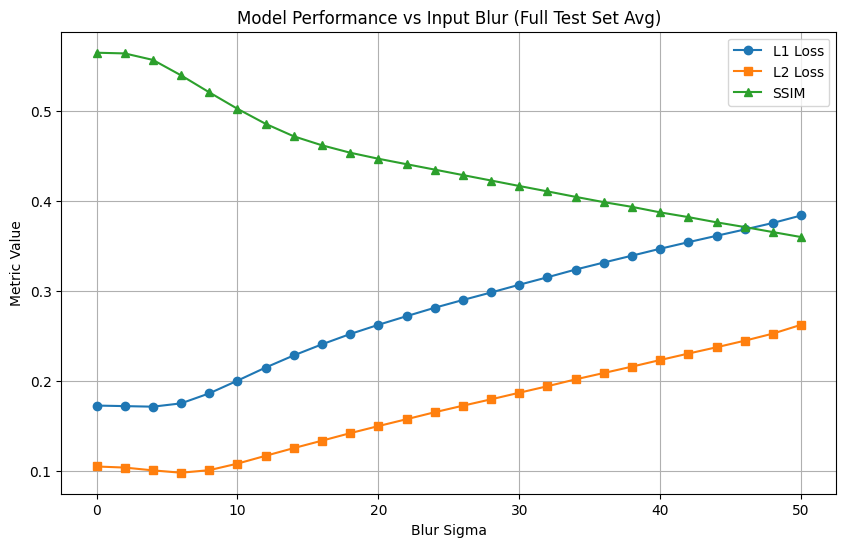

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(blur_sigmas, l1_all, label="L1 Loss", marker='o')
plt.plot(blur_sigmas, l2_all, label="L2 Loss", marker='s')
plt.plot(blur_sigmas, ssim_all, label="SSIM", marker='^')


plt.xlabel("Blur Sigma")
plt.ylabel("Metric Value")
plt.title("Model Performance vs Input Blur (Full Test Set Avg)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for i, sigma in enumerate(blur_sigmas):
    print(f"σ = {sigma:2d} | L1: {l1_all[i]:.4f} | L2: {l2_all[i]:.4f} | SSIM: {ssim_all[i]:.4f} | PSNR: {psnr_all[i]:.2f} dB")